In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
import os
from sqlalchemy import create_engine

In [2]:
client = bigquery.Client(project='subugoe-wag-closed')

In [3]:
openalex_snapshot = 'subugoe-collaborative.openalex.works'
openalex_sources = 'subugoe-collaborative.openalex.sources'
document_type_snapshot = 'subugoe-wag-closed.oal_doctypes.classification_article_reviews_august_2024'
cwts_snapshot = 'subugoe-wag-closed.cwts_2023.pub'
pubmed_snapshot = 'subugoe-wag-closed.pubmed.pubmed_bulk_dec_2022'
pubmed_hierarchy = 'subugoe-wag-closed.pubmed.pubmed_hierarchy'

In [4]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

In [5]:
df_doi = client.query(f"""
                       SELECT COUNT(DISTINCT(oal.doi)) AS n, label
                       FROM {openalex_snapshot} AS oal
                       JOIN {document_type_snapshot} AS dt
                           ON oal.doi = dt.doi
                       GROUP BY label
                       """).to_dataframe()

In [6]:
df_doi[df_doi['label'] == 'editorial_discourse'].n / df_doi.n.sum()

0    0.116721
Name: n, dtype: Float64

In [7]:
df_doi_2012_2021 = client.query(f"""
                                 SELECT COUNT(DISTINCT(oal.doi)) AS n, label
                                 FROM {openalex_snapshot} AS oal
                                 JOIN {document_type_snapshot} AS dt
                                     ON oal.doi = dt.doi
                                 WHERE publication_year BETWEEN 2012 AND 2021
                                 GROUP BY label
                                 """).to_dataframe()

In [8]:
df_doi_2012_2021[df_doi_2012_2021['label'] == 'editorial_discourse'].n / df_doi_2012_2021.n.sum()

0    0.099439
Name: n, dtype: Float64

In [9]:
df_cwts_2012_2021 = client.query(f"""
                                  SELECT COUNT(DISTINCT(cwts.doi)) AS n, 'research_discourse' AS label
                                  FROM {openalex_snapshot} AS oal
                                  LEFT JOIN {cwts_snapshot} AS cwts
                                      ON oal.doi = cwts.doi
                                  WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2012 AND 2021 
                                  """).to_dataframe()

In [10]:
df_oal_2012_2021 = client.query(f"""
                                  SELECT COUNT(DISTINCT(oal.doi)) AS n
                                  FROM {openalex_snapshot} AS oal
                                  WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2012 AND 2021
                                  """).to_dataframe()

In [11]:
df_cwts_2012_2021.n / df_oal_2012_2021.n

0    0.458506
Name: n, dtype: Float64

In [12]:
1 - 0.458506

0.5414939999999999

In [16]:
df_doi_cwts_2012_2022 = client.query(f"""
                                      SELECT COUNT(DISTINCT(oal.doi)) AS n, label
                                      FROM {openalex_snapshot} AS oal
                                      JOIN {document_type_snapshot} AS dt
                                          ON oal.doi = dt.doi
                                      JOIN {cwts_snapshot} AS cwts
                                          ON oal.doi = cwts.doi
                                      WHERE publication_year BETWEEN 2012 AND 2021
                                      GROUP BY label
                                      """).to_dataframe()

In [17]:
df_doi_cwts_2012_2022[df_doi_cwts_2012_2022['label'] == 'editorial_discourse'].n / df_doi_cwts_2012_2022.n.sum()

1    0.011498
Name: n, dtype: Float64

In [25]:
df_cwts_2012_2021 = client.query(f"""
                                  SELECT COUNT(DISTINCT(cwts.doi)) AS n, 'research_discourse' AS label, publication_year
                                  FROM {openalex_snapshot} AS oal
                                  LEFT JOIN {cwts_snapshot} AS cwts
                                      ON oal.doi = cwts.doi
                                  WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2012 AND 2021 
                                  GROUP BY publication_year, label
                                  ORDER BY publication_year DESC
                                  """).to_dataframe()

In [26]:
df_doi_2012_2021 = client.query(f"""
                                 SELECT COUNT(DISTINCT(oal.doi)) AS n, label, publication_year
                                 FROM {openalex_snapshot} AS oal
                                 JOIN {document_type_snapshot} AS dt
                                     ON oal.doi = dt.doi
                                 WHERE publication_year BETWEEN 2012 AND 2021 AND label = 'research_discourse'
                                 GROUP BY publication_year, label
                                 ORDER BY publication_year DESC
                                 """).to_dataframe()

In [27]:
df_oal_2012_2021 = client.query(f"""
                                 SELECT COUNT(DISTINCT(oal.doi)) AS total_n, publication_year
                                 FROM {openalex_snapshot} AS oal
                                 WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2012 AND 2021
                                     AND type IN ('article', 'review')
                                 GROUP BY publication_year
                                 ORDER BY publication_year DESC
                                 """).to_dataframe()

In [154]:
df_oal_2012_2021_baseline = client.query(f"""
                                 SELECT COUNT(DISTINCT(oal.doi)) AS n, publication_year
                                 FROM {openalex_snapshot} AS oal
                                 WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2012 AND 2021
                                     AND ARRAY_LENGTH(referenced_works) != 0 AND cited_by_count != 0
                                 GROUP BY publication_year
                                 ORDER BY publication_year DESC
                                 """).to_dataframe()

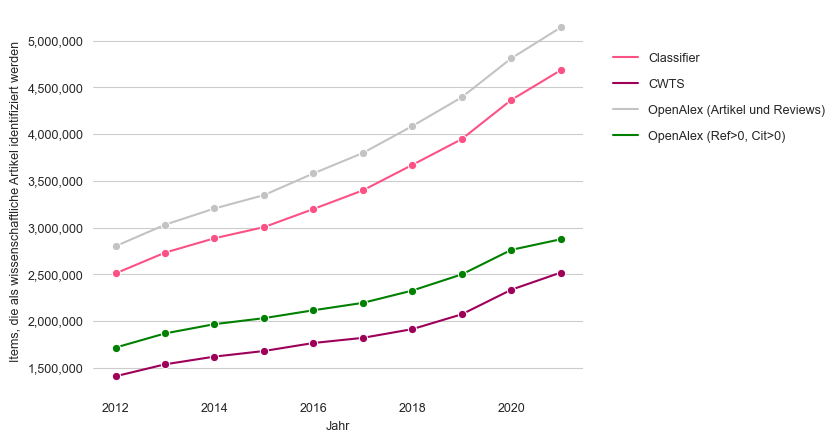

In [155]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=df_doi_2012_2021,
             x='publication_year',
             y='n',
             color='#fc5185',
             marker='o',
             ax=ax)

sns.lineplot(data=df_cwts_2012_2021,
             x='publication_year',
             y='n',
             color='#9e0059',
             marker='o',
             ax=ax)

sns.lineplot(data=df_oal_2012_2021,
             x='publication_year',
             y='total_n',
             color='#c3c3c3',
             marker='o',
             ax=ax)

sns.lineplot(data=df_oal_2012_2021_baseline,
             x='publication_year',
             y='n',
             color='green',
             marker='o',
             ax=ax)

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.grid(False, which='both', axis='x')
ax.set(xlabel='Jahr', ylabel='Items, die als wissenschaftliche Artikel identifiziert werden')

clas_patch = Line2D([0], [0], color='#fc5185', label='Classifier')
cwts_patch = Line2D([0], [0], color='#9e0059', label='CWTS')
oal_patch = Line2D([0], [0], color='#c3c3c3', label='OpenAlex (Artikel und Reviews)')
oal_baseline_patch = Line2D([0], [0], color='green', label='OpenAlex (Ref>0, Cit>0)')

lgd = fig.legend(handles=[clas_patch, cwts_patch, oal_patch, oal_baseline_patch], frameon=False,
                 bbox_to_anchor=(1.4, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()

In [75]:
df_doi_2012_2021_topic = client.query(f"""
                                       SELECT COUNT(DISTINCT(oal.doi)) AS n, label, primary_topic.domain.display_name AS topic
                                       FROM {openalex_snapshot} AS oal
                                       JOIN {document_type_snapshot} AS dt
                                           ON oal.doi = dt.doi
                                       WHERE publication_year BETWEEN 2012 AND 2021
                                       GROUP BY topic, label
                                       """).to_dataframe()

In [76]:
df_doi_2012_2021_topic = df_doi_2012_2021_topic.fillna(value='No topic assigned')

In [77]:
df_doi_2012_2021_topic

,n,label,topic
0,525865,editorial_discourse,No topic assigned
1,1030837,editorial_discourse,Social Sciences
2,4906948,research_discourse,Life Sciences
3,365258,editorial_discourse,Life Sciences
4,612559,editorial_discourse,Physical Sciences
5,8547283,research_discourse,Health Sciences
6,7563675,research_discourse,Social Sciences
7,1262385,editorial_discourse,Health Sciences
8,1363298,research_discourse,No topic assigned
9,12005246,research_discourse,Physical Sciences


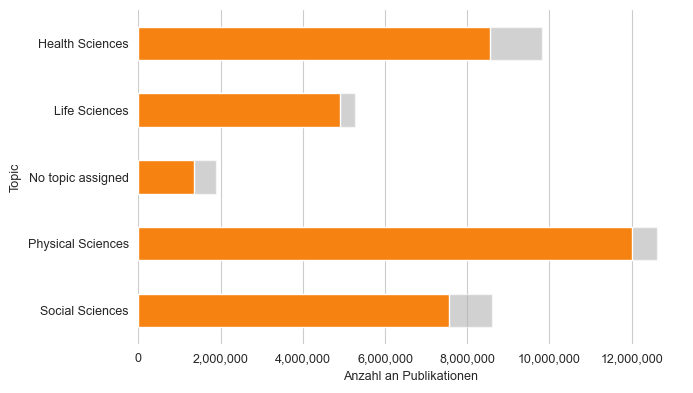

In [78]:
fig, ax = plt.subplots(figsize=(7,4))
plt.box(False)

sns.barplot(data=df_doi_2012_2021_topic.groupby(['topic'])['n'].sum().reset_index(), 
            x='n', 
            y='topic', 
            alpha=0.6,
            color='#b3b3b3a0',
            width=0.5,
            saturation=1,
            errorbar=None)

sns.barplot(data=df_doi_2012_2021_topic[df_doi_2012_2021_topic.label == 'research_discourse'], 
            x='n', 
            y='topic', 
            alpha=1,
            color='#f68212',
            width=0.5,
            saturation=1,
            errorbar=None)

ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

ax.set(xlabel='Anzahl an Publikationen', ylabel='Topic')

plt.tight_layout()

plt.show()

In [30]:
df_doi_2012_2021_oa = client.query(f"""
                                    SELECT COUNT(DISTINCT(oal.doi)) AS n, label, open_access.is_oa AS is_oa
                                    FROM {openalex_snapshot} AS oal
                                    JOIN {document_type_snapshot} AS dt
                                        ON oal.doi = dt.doi
                                    WHERE publication_year BETWEEN 2012 AND 2021
                                    GROUP BY is_oa, label
                                    """).to_dataframe()

In [31]:
df_doi_2012_2021_oa['prop'] = df_doi_2012_2021_oa.n / df_doi_2012_2021_oa.n.sum()

In [32]:
df_doi_2012_2021_oa

,n,label,is_oa,prop
0,17966795,research_discourse,True,0.470543
1,16419454,research_discourse,False,0.430018
2,2017094,editorial_discourse,True,0.052827
3,1779794,editorial_discourse,False,0.046612


In [79]:
df_doi_2012_2021_topic_cwts = client.query(f"""
                                            SELECT COUNT(DISTINCT(oal.doi)) AS oal_n, COUNT(DISTINCT(cwts.doi)) AS cwts_n,
                                                primary_topic.domain.display_name AS topic
                                            FROM {openalex_snapshot} AS oal
                                            LEFT JOIN {cwts_snapshot} AS cwts
                                                ON oal.doi = cwts.doi
                                            WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2012 AND 2021
                                            GROUP BY topic
                                            """).to_dataframe()

In [80]:
df_doi_2012_2021_topic_cwts = df_doi_2012_2021_topic_cwts.fillna(value='No topic assigned')

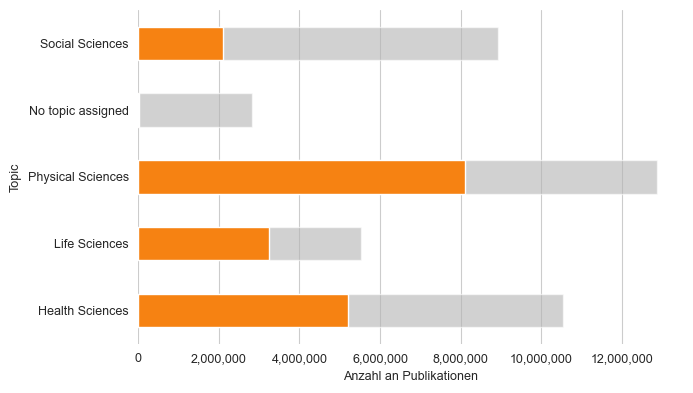

In [81]:
fig, ax = plt.subplots(figsize=(7,4))
plt.box(False)

sns.barplot(data=df_doi_2012_2021_topic_cwts, 
            x='oal_n', 
            y='topic', 
            alpha=0.6,
            color='#b3b3b3a0',
            width=0.5,
            saturation=1,
            errorbar=None)

sns.barplot(data=df_doi_2012_2021_topic_cwts, 
            x='cwts_n', 
            y='topic', 
            alpha=1,
            color='#f68212',
            width=0.5,
            saturation=1,
            errorbar=None)

ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

ax.set(xlabel='Anzahl an Publikationen', ylabel='Topic')

plt.tight_layout()

plt.show()

In [124]:
df_doi_2012_2021_proba_dist = client.query(f"""
                                            SELECT COUNT(DISTINCT(dt.doi)) AS n, ROUND(proba, 1) AS proba_rounded
                                            FROM {openalex_snapshot} AS oal
                                            JOIN {document_type_snapshot} AS dt
                                                ON oal.doi = dt.doi
                                            WHERE publication_year BETWEEN 2012 AND 2021
                                            GROUP BY proba_rounded
                                            """).to_dataframe()

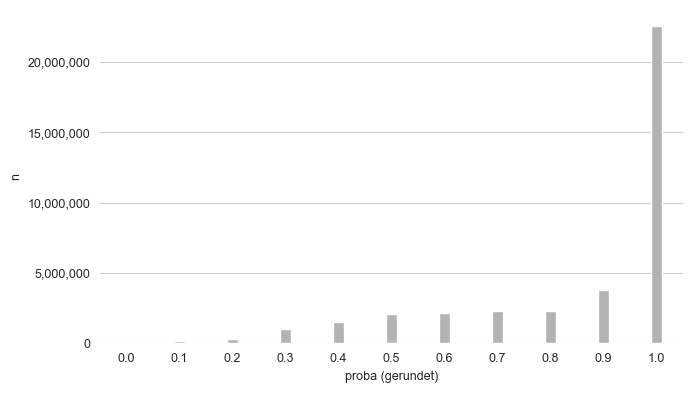

In [149]:
fig, ax = plt.subplots(figsize=(7,4))
plt.box(False)

sns.barplot(data=df_doi_2012_2021_proba_dist, 
            x='proba_rounded', 
            y='n', 
            alpha=1,
            color='#b3b3b3a0',
            width=0.2,
            saturation=1,
            errorbar=None)

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

ax.set(xlabel='proba (gerundet)', ylabel='n')

plt.tight_layout()

plt.show()

In [35]:
df_doi_2012_2021_pubmed = client.query(f"""
                                       SELECT COUNT(DISTINCT(dt.doi)) AS dt_n, COUNT(DISTINCT(pm.doi)) AS pm_n,
                                           label
                                       FROM {openalex_snapshot} AS oal
                                       JOIN {document_type_snapshot} AS dt
                                           ON oal.doi = dt.doi
                                       LEFT JOIN (
                                           SELECT doi 
                                           FROM {pubmed_snapshot} AS pm_snapshot
                                           JOIN {pubmed_hierarchy} AS pm_hierarchy
                                               ON pm_snapshot.grouprank = pm_hierarchy.grouprank
                                           WHERE pm_hierarchy.ptype_group IN ('RCT', 'Case_Reports')
                                       ) AS pm
                                           ON LOWER(oal.doi) = LOWER(pm.doi)
                                       WHERE publication_year BETWEEN 2012 AND 2021
                                       GROUP BY label
                                       """).to_dataframe()

In [36]:
df_doi_2012_2021_pubmed

,dt_n,pm_n,label
0,34386050,802262,research_discourse
1,3796866,27665,editorial_discourse


In [96]:
df_doi_2012_2021_publisher = client.query(f"""
                                           SELECT COUNT(DISTINCT(oal.doi)) AS n, label, 
                                               oal_sources.host_organization_name AS publisher
                                           FROM {openalex_snapshot} AS oal
                                           JOIN {document_type_snapshot} AS dt
                                               ON oal.doi = dt.doi 
                                           JOIN {openalex_sources} AS oal_sources
                                               ON oal.primary_location.source.id = oal_sources.id
                                           WHERE publication_year BETWEEN 2012 AND 2021
                                               AND oal_sources.type = 'journal'
                                           GROUP BY publisher, label
                                           """).to_dataframe()

In [97]:
df_doi_2012_2021_publisher_total = df_doi_2012_2021_publisher.groupby(['publisher'])['n'].sum().reset_index()
df_doi_2012_2021_publisher_total = df_doi_2012_2021_publisher_total.rename(columns={'n': 'n_total'})

In [98]:
df_doi_2012_2021_publisher = df_doi_2012_2021_publisher.merge(df_doi_2012_2021_publisher_total, on='publisher')
df_doi_2012_2021_publisher['prop'] = (df_doi_2012_2021_publisher.n / df_doi_2012_2021_publisher.n_total) * 100

In [151]:
df_doi_2012_2021_publisher[(df_doi_2012_2021_publisher.n_total > 10000) & (df_doi_2012_2021_publisher.label == 'research_discourse')] \
    .sort_values(by='prop', ascending=True).head(10)

,n,label,publisher,n_total,prop
78,28838,research_discourse,"Adis, Springer Healthcare",152582,18.900001
341,6755,research_discourse,Royal Pharmaceutical Society,15158,44.563927
48,15299,research_discourse,Royal College of Nursing,33161,46.135521
5352,8688,research_discourse,OpenEdition Journals,18420,47.166124
8070,18737,research_discourse,Case Journals,38202,49.04717
8013,15352,research_discourse,Massachusetts Medical Society,27010,56.838208
2786,7424,research_discourse,International Union of Crystallography,12800,58.0
2704,19842,research_discourse,EMH Swiss Medical Publishers Ltd.,33637,58.988614
56,8964,research_discourse,AIP Publishing,14679,61.06683
3232,7478,research_discourse,Indiana University Press,11482,65.128026


In [150]:
df_doi_2012_2021_publisher[(df_doi_2012_2021_publisher.n_total > 10000) & (df_doi_2012_2021_publisher.label == 'research_discourse')] \
    .sort_values(by='prop', ascending=False).head()

,n,label,publisher,n_total,prop
10495,189657,research_discourse,Trans Tech Publications,189697,99.978914
5304,11401,research_discourse,Ivyspring International Publisher,11413,99.894857
2690,13436,research_discourse,"PeerJ, Inc.",13452,99.881059
196,21942,research_discourse,Excellent Publishers,21972,99.863463
5366,46707,research_discourse,Spandidos Publishing,46799,99.803415


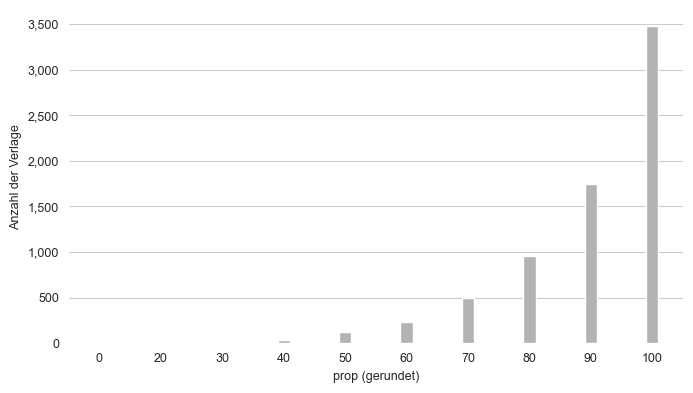

In [148]:
df_plot = df_doi_2012_2021_publisher[df_doi_2012_2021_publisher.label == 'research_discourse'].copy()
df_plot['prop_rounded'] = df_plot['prop'].apply(lambda x: round(x / 10) * 10)
df_plot = df_plot.groupby(['prop_rounded']).publisher.count().reset_index()

fig, ax = plt.subplots(figsize=(7,4))
plt.box(False)

sns.barplot(data=df_plot, 
            x='prop_rounded', 
            y='publisher', 
            alpha=1,
            color='#b3b3b3a0',
            width=0.2,
            saturation=1,
            errorbar=None)

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

ax.set(xlabel='prop (gerundet)', ylabel='Anzahl der Verlage')

plt.tight_layout()

plt.show()

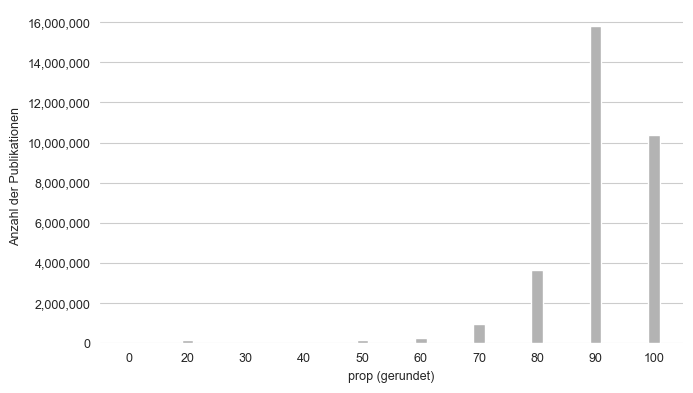

In [147]:
df_plot = df_doi_2012_2021_publisher[df_doi_2012_2021_publisher.label == 'research_discourse'].copy()
df_plot['prop_rounded'] = df_plot['prop'].apply(lambda x: round(x / 10) * 10)
df_plot = df_plot.groupby(['prop_rounded']).n_total.sum().reset_index()

fig, ax = plt.subplots(figsize=(7,4))
plt.box(False)

sns.barplot(data=df_plot, 
            x='prop_rounded', 
            y='n_total', 
            alpha=1,
            color='#b3b3b3a0',
            width=0.2,
            saturation=1,
            errorbar=None)

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

ax.set(xlabel='prop (gerundet)', ylabel='Anzahl der Publikationen')

plt.tight_layout()

plt.show()

## Abgleich mit dem KB

In [6]:
host = os.environ['KB_HOST']
database = os.environ['KB_DATABASE']
user = os.environ['KB_USER']
pw = os.environ['KB_PASSWORD']
port = os.environ['KB_PORT']
engine = create_engine(f'postgresql://{user}:{pw}@{host}:{port}/{database}')

In [164]:
scp_cla_n = pd.read_sql("""
                        SELECT COUNT(DISTINCT(dt.doi)) AS n, label
                        FROM unignhaupka.classification_article_reviews_august_2024 AS dt
                        JOIN scp_b_202404.items scp
                            ON LOWER(dt.doi) = LOWER(scp.doi)
                        WHERE ('Article' = ANY(item_type) OR 'Review' = ANY(item_type)) AND (scp.pubyear BETWEEN 2012 AND 2021)
                        GROUP BY label
                        """, 
                        con=engine)

In [166]:
scp_cla_n[scp_cla_n['label'] == 'editorial_discourse'].n / scp_cla_n.n.sum()

0    0.012732
Name: n, dtype: float64

In [7]:
scp_oal_n = pd.read_sql("""
                        SELECT COUNT(DISTINCT(oal.doi)) AS oal_n, COUNT(DISTINCT(scp.doi)) AS scp_n
                        FROM fiz_openalex_bdb_20240427.items AS oal
                        LEFT JOIN (
                            SELECT DISTINCT doi
                            FROM scp_b_202404.items scp_items
                            WHERE ('Article' = ANY(scp_items.item_type) OR 'Review' = ANY(scp_items.item_type)) AND 
                                (scp_items.pubyear BETWEEN 2012 AND 2021)
                        ) AS scp
                            ON LOWER(oal.doi) = LOWER(scp.doi)
                        WHERE 'article' = ANY(oal.item_type) AND oal.source_type = 'journal' AND oal.pubyear BETWEEN 2012 AND 2021
                        """, 
                        con=engine)

In [8]:
scp_oal_n

,oal_n,scp_n
0,38117108,19514958


In [9]:
19514958 / 38117108

0.5119737310606041

In [10]:
1 - 0.5119737310606041

0.48802626893939594

In [25]:
oal_n = pd.read_sql("""
                    SELECT COUNT(DISTINCT(oal.doi)) AS n, scp.pubyear 
                    FROM unignhaupka.oal_dois_2024 AS oal
                    JOIN scp_b_202404.items AS scp
                        ON LOWER(oal.doi) = LOWER(scp.doi)
                    WHERE (oal_type = 'article' OR oal_type = 'review') AND scp.pubyear BETWEEN 2012 AND 2021
                    GROUP BY scp.pubyear
                    """, 
                    con=engine)

In [26]:
scp_n = pd.read_sql("""
                    SELECT COUNT(DISTINCT(oal.doi)) AS n, scp.pubyear
                    FROM unignhaupka.oal_dois_2024 AS oal
                    JOIN scp_b_202404.items AS scp
                        ON LOWER(oal.doi) = LOWER(scp.doi)
                    WHERE scp.pubyear BETWEEN 2012 AND 2021
                        AND ('Article' = ANY(scp.item_type) OR 'Review' = ANY(scp.item_type))
                    GROUP BY scp.pubyear
                    """, 
                    con=engine)

In [27]:
dt_n = pd.read_sql("""
                   SELECT COUNT(DISTINCT(oal.doi)) AS n, scp.pubyear
                   FROM unignhaupka.oal_dois_2024 AS oal
                   JOIN scp_b_202404.items AS scp
                       ON LOWER(oal.doi) = LOWER(scp.doi)
                   JOIN unignhaupka.classification_article_reviews_august_2024 AS dt
                       ON LOWER(dt.doi) = LOWER(oal.doi)
                   WHERE scp.pubyear BETWEEN 2012 AND 2021 AND label = 'research_discourse'
                   GROUP BY scp.pubyear
                   """, 
                   con=engine)

In [7]:
oal_n = pd.read_sql("""
                    SELECT COUNT(DISTINCT(doi)) AS n
                    FROM unignhaupka.oal_wos_scp_s2_pubmed_comparison_2012_22
                    WHERE oal_type = 'article'
                    """, 
                    con=engine)

In [8]:
scp_n = pd.read_sql("""
                    SELECT COUNT(DISTINCT(doi)) AS n
                    FROM unignhaupka.oal_wos_scp_s2_pubmed_comparison_2012_22
                    WHERE ('Article' = ANY(scp_type) OR 'Review' = ANY(scp_type))
                    """, 
                    con=engine)

In [9]:
dt_n = pd.read_sql("""
                   SELECT COUNT(DISTINCT(c.doi)) AS n
                   FROM unignhaupka.oal_wos_scp_s2_pubmed_comparison_2012_22 c
                   JOIN unignhaupka.classification_article_reviews_august_2024 AS dt
                       ON LOWER(dt.doi) = LOWER(c.doi)
                   WHERE label = 'research_discourse'
                   """, 
                   con=engine)

In [22]:
oal24_n = pd.read_sql("""
                      SELECT COUNT(DISTINCT(c.doi)) AS n
                      FROM unignhaupka.oal_wos_scp_s2_pubmed_comparison_2012_22 c
                      JOIN unignhaupka.oal_dois_2024 o
                          ON LOWER(c.doi) = LOWER(o.doi)
                      WHERE o.oal_type = 'article' OR o.oal_type = 'review'
                      """, 
                      con=engine)

In [10]:
all_n = pd.read_sql("""
                    SELECT COUNT(DISTINCT(doi)) AS n
                    FROM unignhaupka.oal_wos_scp_s2_pubmed_comparison_2012_22
                    """, 
                    con=engine)

In [15]:
oal_n.n / all_n.n

0    0.994967
Name: n, dtype: float64

In [16]:
scp_n.n / all_n.n

0    0.892001
Name: n, dtype: float64

In [17]:
dt_n.n / all_n.n

0    0.90819
Name: n, dtype: float64

In [23]:
oal24_n.n / all_n.n

0    0.92089
Name: n, dtype: float64

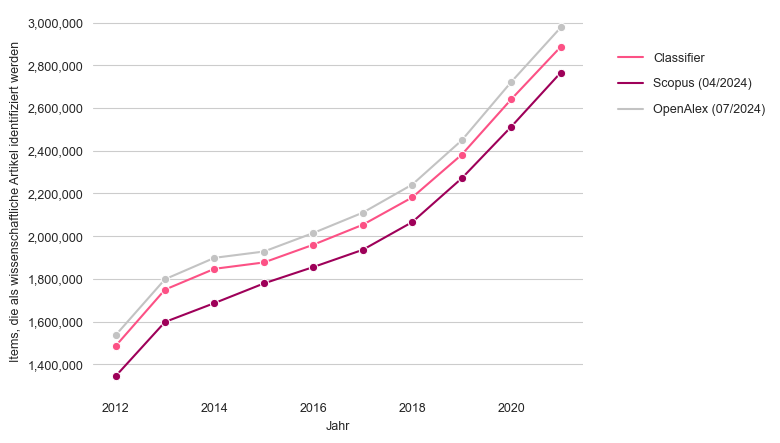

In [39]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=oal_n,
             x='pubyear',
             y='n',
             color='#c3c3c3',
             marker='o',
             ax=ax)

sns.lineplot(data=scp_n,
             x='pubyear',
             y='n',
             color='#9e0059',
             marker='o',
             ax=ax)

sns.lineplot(data=dt_n,
             x='pubyear',
             y='n',
             color='#fc5185',
             marker='o',
             ax=ax)

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.grid(False, which='both', axis='x')
ax.set(xlabel='Jahr', ylabel='Items, die als wissenschaftliche Artikel identifiziert werden')

clas_patch = Line2D([0], [0], color='#fc5185', label='Classifier')
scp_patch = Line2D([0], [0], color='#9e0059', label='Scopus (04/2024)')
oal_patch = Line2D([0], [0], color='#c3c3c3', label='OpenAlex (07/2024)')

lgd = fig.legend(handles=[clas_patch, scp_patch, oal_patch], frameon=False,
                 bbox_to_anchor=(1.3, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()